Load all necessary imports

In [1]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers
import cv2
import matplotlib.pyplot as plt
import h5py

# Configure Keras to use GPU
config = tf.compat.v1.ConfigProto()
config.gpu_options.allow_growth = True
sess = tf.compat.v1.Session(config=config)
tf.compat.v1.keras.backend.set_session(sess)

2024-03-12 19:29:11.372182: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-03-12 19:29:11.405298: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-03-12 19:29:11.405326: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-03-12 19:29:11.406186: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-03-12 19:29:11.411608: I tensorflow/core/platform/cpu_feature_guar

Data Loading

In [2]:
with h5py.File('TrainingData5zeroes.h5', 'r') as hdf:
    ls = list(hdf.keys())
    images = hdf.get('images')
    boxes = hdf.get('boxes')
    images = np.array(images)
    boxes = np.array(boxes)

Data Normalization

In [3]:
image_normalized = (images+1e-9)/9.26 # Normalize images and add noise


# Normalize bounding boxes
normalized_boxes = boxes / [1,64,64,64,64]

Model Train


In [4]:
from tensorflow.keras import layers, models



input_shape = (64, 64, 1)
num_classes = 280
num_coordinates = 4

images_np = image_normalized
#images_np = tf.expand_dims(images_np, axis=-1)
probabilities = np.array(normalized_boxes[:, :,:-4])
probabilities = tf.expand_dims(probabilities, axis=1)
boxes_np = np.array(normalized_boxes[:, :, 1:])
boxes_np = tf.expand_dims(boxes_np, axis=1)

dataset = tf.data.Dataset.from_tensor_slices((images_np,{'x_prob_reshape':probabilities,'x_boxes_reshape':boxes_np}))

# Assuming dataset has 10,000 examples and we want an 80/20 split
total_items = 10000
train_size = int(total_items * 0.6)
val_size = total_items - train_size

# Splitting the dataset
train_dataset = dataset.take(train_size)
val_dataset = dataset.skip(train_size)


train_dataset = train_dataset.shuffle(buffer_size=train_size,reshuffle_each_iteration=True)
train_dataset = train_dataset.batch(64)
val_dataset = val_dataset.batch(64) 



x_input = layers.Input(shape=input_shape)

x = layers.Conv2D(64, kernel_size=3, padding='same', activation='relu')(x_input)
x = layers.MaxPool2D()(x)
x = layers.BatchNormalization()(x) 

x = layers.Conv2D(64, kernel_size=3, padding='same', activation='relu')(x)
 

x = layers.Conv2D(128, kernel_size=3, padding='same', activation='relu')(x)


x = layers.Conv2D(128, kernel_size=3, padding='same', activation='relu')(x)


x = layers.Conv2D(256, kernel_size=3, padding='same', activation='relu')(x)


x = layers.Conv2D(256, kernel_size=3, padding='same', activation='relu')(x)


x = layers.Conv2D(512, kernel_size=3, padding='same', activation='relu')(x)
x = layers.MaxPool2D()(x)


x = layers.Conv2D(512, kernel_size=3, padding='same', activation='relu')(x)
x = layers.MaxPool2D()(x)


x = layers.Conv2D(512, kernel_size=3, padding='same', activation='relu')(x)
x = layers.MaxPool2D()(x)


x = layers.Conv2D(256, kernel_size=5, padding='same', activation='relu')(x)
x = layers.MaxPool2D()(x)
x = layers.BatchNormalization()(x) # size: 8x8x


x = layers.Flatten()(x)
# Bounding box output
x_prob = layers.Dense(num_classes, activation='sigmoid', name='x_prob')(x)
x_prob_reshape = layers.Reshape((-1, num_classes, 1), name='x_prob_reshape')(x_prob)

x_boxes = layers.Dense(num_classes * num_coordinates, activation='sigmoid', name='x_boxes')(x)
x_boxes_reshape = layers.Reshape((-1, num_classes, num_coordinates), name='x_boxes_reshape')(x_boxes)


model = tf.keras.models.Model(x_input, [x_prob_reshape, x_boxes_reshape])


optimizer = tf.keras.optimizers.Adam(learning_rate=3e-5)  # Consider adjusting based on performance





model.compile(optimizer= optimizer, loss= {'x_prob_reshape': tf.keras.losses.BinaryCrossentropy(), 'x_boxes_reshape':tf.keras.losses.MeanSquaredError()}, metrics={'x_prob_reshape': 'accuracy'} )
num_epochs = 3000


2024-03-12 19:29:22.777085: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1929] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 21925 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3090, pci bus id: 0000:68:00.0, compute capability: 8.6


In [5]:
# Assuming you've already prepared train_dataset and val_dataset as shown previously

# Fit the model
history = model.fit(
    train_dataset,  # Training data
    epochs=num_epochs,  # Number of epochs
    validation_data=val_dataset  # Validation data
    
        # Add other callbacks here as needed, such as ModelCheckpoint or ReduceLROnPlateau
    
)





Epoch 1/3000


2024-03-12 19:29:28.429612: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8904
2024-03-12 19:29:28.684891: I external/local_tsl/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2024-03-12 19:29:29.497149: I external/local_tsl/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2024-03-12 19:29:30.668880: I external/local_xla/xla/service/service.cc:168] XLA service 0x7e80606735c0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-03-12 19:29:30.668924: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 3090, Compute Capability 8.6
2024-03-12 19:29:30.687980: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1710286170.861393    4717 device_compiler.

94/94 [==============================] - 20s 95ms/step - loss: 0.4291 - x_prob_reshape_loss: 0.3098 - x_boxes_reshape_loss: 0.1194 - x_prob_reshape_accuracy: 0.8843 - val_loss: 0.6964 - val_x_prob_reshape_loss: 0.5835 - val_x_boxes_reshape_loss: 0.1129 - val_x_prob_reshape_accuracy: 0.7470
Epoch 2/3000
94/94 [==============================] - 5s 54ms/step - loss: 0.1728 - x_prob_reshape_loss: 0.1290 - x_boxes_reshape_loss: 0.0438 - x_prob_reshape_accuracy: 0.9639 - val_loss: 0.6074 - val_x_prob_reshape_loss: 0.5133 - val_x_boxes_reshape_loss: 0.0941 - val_x_prob_reshape_accuracy: 0.7808
Epoch 3/3000
94/94 [==============================] - 5s 53ms/step - loss: 0.1308 - x_prob_reshape_loss: 0.0961 - x_boxes_reshape_loss: 0.0347 - x_prob_reshape_accuracy: 0.9702 - val_loss: 0.6976 - val_x_prob_reshape_loss: 0.5983 - val_x_boxes_reshape_loss: 0.0993 - val_x_prob_reshape_accuracy: 0.7996
Epoch 4/3000
94/94 [==============================] - 5s 53ms/step - loss: 0.1121 - x_prob_reshape_loss

In [35]:
model.save('M11overfittedmodel.h5')



In [36]:
model.save('M11overfittedmodel1.keras')

In [53]:
# loaded_model = tf.keras.models.load_model('model5zeroes.h5')


In [10]:
boxes.shape

(10000, 280, 5)

In [40]:
dataset = tf.data.Dataset.from_tensor_slices((images_np,{'x_prob_reshape':probabilities,'x_boxes_reshape':boxes_np}))

# Assuming dataset has 10,000 examples and we want an 80/20 split
total_items = 10000
train_size = int(total_items * 0.6)
# val_size = total_items - train_size

# Splitting the dataset
train_dataset = dataset.take(train_size)
# val_dataset = dataset.skip(train_size)


# train_dataset = train_dataset.shuffle(buffer_size=train_size,reshuffle_each_iteration=True)
train_dataset = train_dataset.batch(2000)
inputs,targets = next(iter(train_dataset))
output = model.predict(inputs)

63/63 [==============================] - 1s 11ms/step


In [25]:
targets['x_boxes_reshape'][0]

<tf.Tensor: shape=(1, 280, 4), dtype=float64, numpy=
array([[[0.03125 , 0.671875, 0.03125 , 0.6875  ],
        [0.359375, 0.84375 , 0.375   , 0.84375 ],
        [0.390625, 0.5     , 0.390625, 0.515625],
        ...,
        [0.      , 0.      , 0.      , 0.      ],
        [0.      , 0.      , 0.      , 0.      ],
        [0.      , 0.      , 0.      , 0.      ]]])>

In [26]:
output[1][0]

array([[[3.7099853e-02, 7.0229399e-01, 3.3685271e-02, 7.0858943e-01],
        [3.6892897e-01, 8.5534781e-01, 3.9331496e-01, 8.6018938e-01],
        [3.8751069e-01, 4.9317157e-01, 3.9496177e-01, 5.1479810e-01],
        ...,
        [4.3258809e-05, 6.0362901e-05, 3.4218003e-05, 5.8473321e-05],
        [7.7795477e-05, 2.1464365e-04, 1.9817089e-05, 8.3129935e-06],
        [3.1174372e-05, 2.7679231e-05, 9.7896715e-05, 4.3566281e-05]]],
      dtype=float32)

In [41]:
import tensorflow as tf

r = np.random.randint(0,100)
tensor1 = tf.constant(targets['x_prob_reshape'], dtype=tf.float64)

tensor2 = tf.constant(output[0], dtype=tf.float32)


tensor2 = tf.cast(tensor2, tf.float64)


mse_loss_fn =  tf.keras.losses.BinaryCrossentropy()
mse_loss = mse_loss_fn(tensor1, tensor2)

print("MSE Loss:", mse_loss.numpy())


MSE Loss: 2.1573548268955573e-07


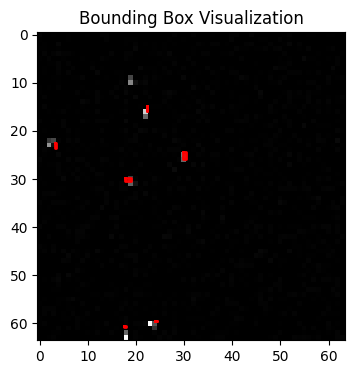

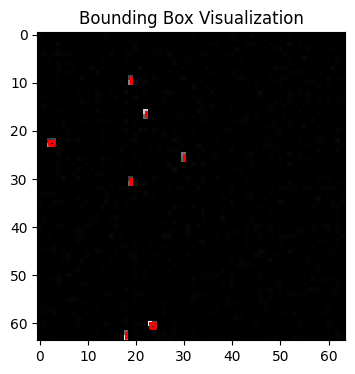

In [45]:
def visualize_bounding_boxes(image, probability_vector, bounding_box_coordinates, threshold=0.9):
    """
    Visualizes bounding boxes on an image based on a probability vector.

    Parameters:
    - image: A 3D tensor representing the image.
    - probability_vector: A 1D tensor representing the probabilities associated with bounding boxes.
    - bounding_box_coordinates: A 2D tensor representing bounding box coordinates.
    - threshold: Probability threshold for visualization.

    Returns:
    None (displays the image with bounding boxes).
    """
    # Convert to NumPy arrays for easier handling
    image_np = image
    prob_vector_np = probability_vector
    bbox_coordinates_np = bounding_box_coordinates
   # Denormalize image if necessary (adjust based on your normalization method)
    denormalized_image = image_np  # Modify if normalization was applied during training

    # Visualize the image
    plt.figure(figsize=(4, 4))
    plt.imshow(denormalized_image, cmap='gray')
    plt.title("Bounding Box Visualization")

    # Plot bounding boxes based on probability threshold
    for i in range(len(prob_vector_np)):
        prob = prob_vector_np[i]
        bbox = bbox_coordinates_np[i]
        if prob > threshold:
            # Denormalize bounding box coordinates if necessary
            denormalized_bbox = bbox  # Modify if normalization was applied during training
            y1, x1, y2, x2 = denormalized_bbox
            plt.plot([x1, x2, x2, x1, x1],[y1, y1, y2, y2, y1],
                     
                     color='r', linewidth=2, label='Bounding Box')

   






   
    plt.show()

t = np.random.randint(0,64)


visualize_bounding_boxes(tf.convert_to_tensor(inputs[299]), probabilities.numpy()[299].squeeze(), tf.convert_to_tensor(output[1][299,0,:,:])*[64,64,64,64]) ##myprediction
visualize_bounding_boxes(tf.convert_to_tensor(image_normalized[299]), probabilities.numpy()[299].squeeze(), tf.convert_to_tensor(boxes_np[299,0,:,:])*[64,64,64,64]) ##myprediction



